In [1]:
import pyvips
import cv2
from skimage.transform import resize, rescale
from PIL import Image
import imutils
from scipy.ndimage import shift, binary_fill_holes, label

import SimpleITK as sitk

import numpy as np
import pandas as pd


import scanpy as sc
import anndata

import os
import warnings
from glob import glob
from pathlib import Path

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

sc._settings.settings._vector_friendly=True

In [ ]:
""" This notebook shows how to align H&E image with spmetabo data
    and transfer annotation masks to spmetabo data """

In [2]:
def adata2img(adata, batch, charge, scaled=True, resized=False, saveit=True, verbose=True):
    adata_sub = adata[adata.obs.batch == batch]
    xmax = adata_sub.obs.x_pixel.max()+1
    ymax = adata_sub.obs.y_pixel.max()+1
    img = np.zeros((ymax,xmax)) 
    img[adata_sub.obs.y_pixel, adata_sub.obs.x_pixel] = adata_sub.layers['counts'].sum(axis=1)#adata_sub.obs[colnm].astype('int') 

    if scaled:
        img = (img - img.min()) / (img.max() - img.min())
        if verbose:
            print('intensity was scaled')

    if resized:
        if verbose:
            print('before resizing: ', img.shape)
        r = img.shape[0] / img.shape[1]
        if r > 1:
            img = imutils.resize(img, width=200)
        else:
            img = imutils.resize(img, height=200)

        if verbose:
            print('after resizing: ', img.shape)

    if saveit:
        # create directory if it does not exist
        p = Path('../data/spmeta_hne_img')
        p.mkdir(parents=True, exist_ok=True)

        savenm = '../data/spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch)
        # cv2.imwrite(savenm, img)
        mpl.image.imsave(savenm,img)
        if verbose:
            print('img was saved as {}'.format(savenm))
    
    if verbose:
        plt.imshow(img)


    return img


In [3]:
def svs2img(fn_sid):
    image = pyvips.Image.new_from_file(fn_sid)
    img = image.numpy()
    return img

In [4]:
def findbatchid(sid, charge, meta_sid, metadb):
    meta_tmp = meta_sid.query('slideid == @sid & ions == @charge')
    meta_tmp = meta_tmp.dropna(axis=1)

    df = []
    for position in meta_tmp.drop(['slideid','ions'], axis=1).columns:
        metadb_tmp = metadb[metadb.slide_id == meta_tmp[position].values[0]]
        batch = 'pid{}_{}'.format(metadb_tmp.pid.values[0], metadb_tmp.time.values[0])
        df.append([position, batch])
    df = pd.DataFrame(df)
    df.columns = ['position','batchid']
    df.index = df.batchid
    df = df.drop(['batchid'],axis=1)
    return df

In [5]:
def cutnscale(img, xmin, xmax, ymin, ymax, charge, 
              erdl=True, k=70,
              resized=True, l_img=200,
              saveit=True, verbose=True):
    img = img[xmin:xmax, ymin:ymax, :3]
    img = cv2.rotate(img, cv2.ROTATE_180)

    if verbose:
        plt.imshow(img)

    if erdl:
        if verbose:
            print('To fill the gaps in tissue, perform erode/dilate')
        # Creating kernel 
        kernel = np.ones((k, k), np.uint8) 
          
        # Using cv2.erode() method  
        img = cv2.erode(img, kernel)  
        img = cv2.dilate(img, kernel)  

        if verbose:
            plt.imshow(img)

    if resized:
        if verbose:
            print('before resizing: ', img.shape)
        r = img.shape[0] / img.shape[1]
        if r > 1:
            img = imutils.resize(img, height=l_img)
        else:
            img = imutils.resize(img, width=l_img)

        if verbose:
            print('after resizing: ', img.shape)

    if saveit:
        # create directory if it does not exist
        p = Path('../data/spmeta_hne_img')
        p.mkdir(parents=True, exist_ok=True)
        
        savenm = '../data/spmeta_hne_img/hne_{}_{}.png'.format(charge, batch)
        if erdl:
            savenm = savenm.replace('.png','_erdl.png')
        mpl.image.imsave(savenm, img)
        if verbose:
            print('img was saved as {}'.format(savenm))
    
    if verbose:
        plt.imshow(img)


In [6]:
def command_iteration(method):
    """ Callback invoked when the optimization has an iteration """
    if method.GetOptimizerIteration() == 0:
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():7.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

def alignimgs(batch, charge, verbose=True):
    if os.path.isfile('../data/spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch)):
        fixed = sitk.ReadImage('../data/spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch), sitk.sitkFloat32)
        moving = sitk.ReadImage('../data/spmeta_hne_img/hne_{}_{}_erdl.png'.format(charge, batch), sitk.sitkFloat32)
    
        moving2 = sitk.ReadImage('../data/spmeta_hne_img/hne_{}_{}.png'.format(charge, batch), sitk.sitkFloat32)
    
        R = sitk.ImageRegistrationMethod()
        R.SetMetricAsCorrelation()
        R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                   minStep=1e-4,
                                                   numberOfIterations=500,
                                                   gradientMagnitudeTolerance=1e-8 )
        R.SetOptimizerScalesFromIndexShift()  
        tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity2DTransform())
        R.SetInitialTransform(tx) 
        R.SetInterpolator(sitk.sitkLinear)
        R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
    
        outTx = R.Execute(fixed, moving)

        # create directory if it does not exist
        p = Path('../results/transform_models')
        p.mkdir(parents=True, exist_ok=True)
    
        savenm = '../results/transform_models/tfm_{}_{}.hdf'.format(charge, batch)
        sitk.WriteTransform(outTx, savenm)
        print('saved: ', savenm)
    
        if verbose:
            print("-------")
            print(outTx)
            print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
            print(" Iteration: {0}".format(R.GetOptimizerIteration()))
            print(" Metric value: {0}".format(R.GetMetricValue()))
    
        
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed);
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(100)
        resampler.SetTransform(outTx)
        
        out = resampler.Execute(moving2)
        simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
        cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
    
        nda = sitk.GetArrayFromImage(cimg)
        
        if verbose:
            plt.imshow(nda[:,:,2])
    
        return nda

In [7]:
# slide id
sid = '38828'
# H&E slide file name in svs format
fsid = '../data/heslides/{}.svs'.format(sid)

In [ ]:
# read spmetabo anndata of both positive and negative panels

In [8]:
adata_pos = sc.read('../data/adata_spmetabo_pos.h5ad')

In [9]:
adata_neg = sc.read('../data/adata_spmetabo_neg.h5ad')

In [10]:
# metadata for each tissue position in each slide
meta_sid = pd.read_csv('/common/yangy4/tunji_spmeta/metadb_slideid.csv', dtype=str)

In [11]:
# metadata for sample information (e.g., patient id, pre/post treatment status) and slide id 
metadb = pd.read_csv('/common/yangy4/tunji_spmeta/fromMETASPACE/metadb_spmeta.csv', dtype=str)

In [12]:
# read svs image and return as an image array
img = svs2img(fsid)

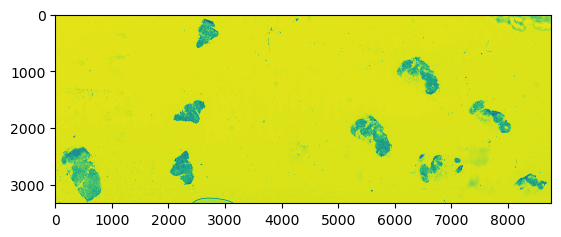

In [13]:
# show slide image at lower resolution
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [14]:
# set anndata based on the charge of slide panel (positive or negative)
charge = meta_sid.query('slideid == @sid')['ions'].values[0]
if charge == 'pos':
    adata = adata_pos.copy()
else:
    adata = adata_neg.copy()

In [15]:
# return batchid and tissue location in this slide 
df_sample_pos = findbatchid(sid, charge, meta_sid, metadb)
df_sample_pos

,position
batchid,
pid7_day1,left
pid9_day1,middle
pid5_day60,right


In [16]:
# set columns for crop indices for each tissue
df_sample_pos[['xmin','xmax','ymin','ymax']] = 0
# set column for slide id and ion panel
df_sample_pos[['sid', 'ions']] = [sid, charge]


In [17]:
batch = 'pid7_day1'

img was saved as ../data/spmeta_hne_img/spmeta_pos_pid7_day1.png


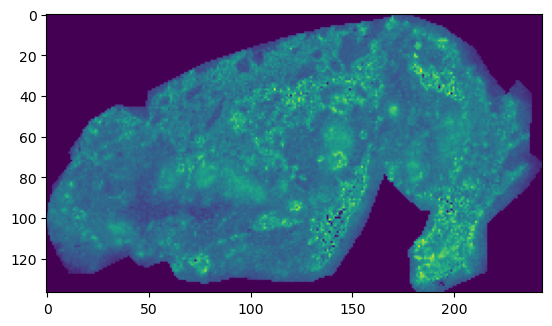

In [18]:
# return an image array from xy coordinates on anndata
template = adata2img(adata, batch, charge, scaled=False, resized=False, saveit=True, verbose=True)

In [19]:
# image length at longer side
l_img = np.max(template.shape)

In [20]:
# define crop indices based on tissue location
xmin = 24000
xmax = 30000
ymin = 63000
ymax = 73000

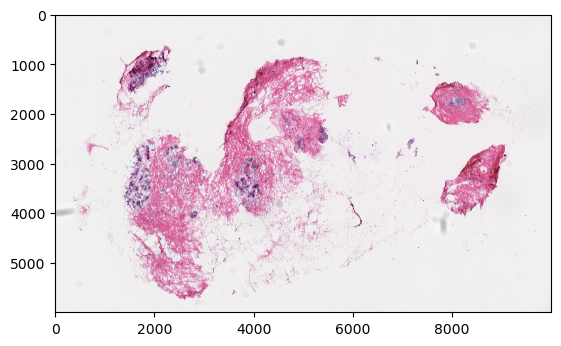

In [21]:
# check if image was cropped well 
plt.imshow(img[xmin:xmax, ymin:ymax, :3])

In [22]:
# store crop indices to dataframe
df_sample_pos.loc[batch, 'xmin'] = xmin
df_sample_pos.loc[batch, 'xmax'] = xmax
df_sample_pos.loc[batch, 'ymin'] = ymin
df_sample_pos.loc[batch, 'ymax'] = ymax

To fill the gaps in tissue, perform erode/dilate
before resizing:  (6000, 10000, 3)
after resizing:  (146, 244, 3)
img was saved as ../data/spmeta_hne_img/hne_pos_pid7_day1_erdl.png


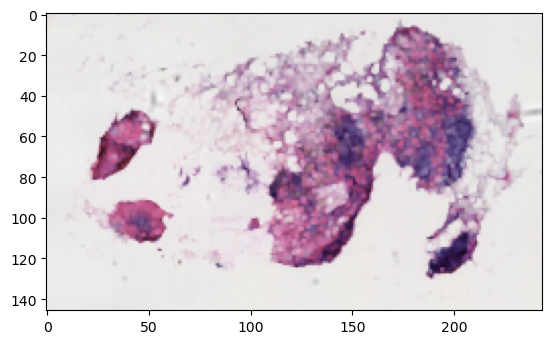

In [23]:
# cut image based on the crop indices, then rescale so that it's similar size as spmetabo image
# perform erosion/dilation to make more solid-like shape of image -- this might be helpful to align with spmetabo since spmetabo is in very low resolution
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=True, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

before resizing:  (6000, 10000, 3)
after resizing:  (146, 244, 3)
img was saved as ../data/spmeta_hne_img/hne_pos_pid7_day1.png


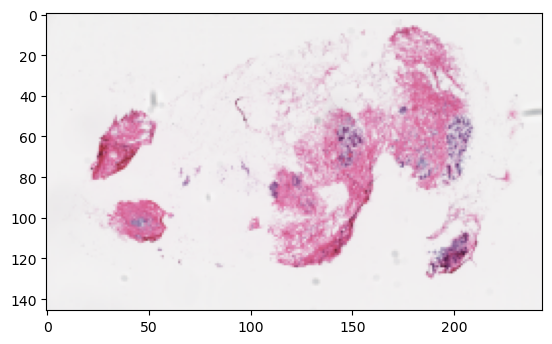

In [24]:
# without erosion/dilation
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=False, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

Estimated Scales:  (20757.569925887186, 20757.396946714365, 1.0000000000010232, 1.0000000000038654)
  0 = -0.16152 : (1.005302277017627, -0.0013461476894789928, -5.884424188440541, 2.804333217275099)
  1 = -0.19270 : (1.0086789411464803, -0.0022467238717071313, -3.884428931727031, 2.8069332606138175)
  2 = -0.21175 : (1.0079163900688521, -0.0017727876968642315, -1.9004660583329946, 2.554167537276109)
  3 = -0.22357 : (1.0009458341497635, -6.429049702732018e-06, 0.027934766504217556, 2.0238671034704514)
  4 = -0.23117 : (0.9875029637028223, 0.0017574669864510294, 1.964259044758866, 1.5234028516536657)
  5 = -0.25023 : (0.9724802497500546, 0.0026828918939326113, 3.8153584148130104, 0.7663000951936308)
  6 = -0.27005 : (0.9551240860759799, 0.0026272751003093672, 5.590155134614463, -0.15554336433260385)
  7 = -0.29115 : (0.9339571877285988, 0.003760434827231395, 5.379055639950235, -2.1442584474241695)
  8 = -0.28696 : (0.9345774899532938, 0.0046500599109522795, 5.754883286367256, -1.217569

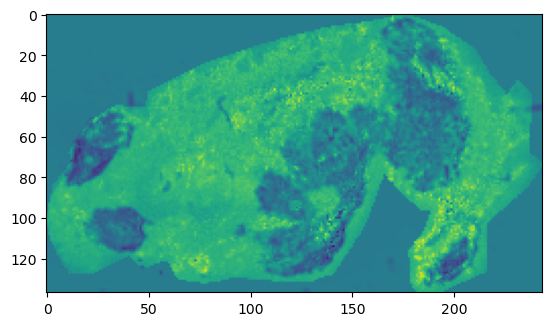

In [25]:
# align images
a = alignimgs(batch, charge, verbose=True)

In [26]:
# In this example notebook, we are only looking at one tissue image, so let's delete the rows for other tissues
df_sample_pos.drop(['pid9_day1', 'pid5_day60'], inplace=True)

In [27]:
df_sample_pos

,position,xmin,xmax,ymin,ymax,sid,ions
batchid,,,,,,,
pid7_day1,left,24000,30000,63000,73000,38828,pos


In [ ]:
# crop h&e image based on the pre-defined crop indices

In [28]:
for sid in df_sample_pos.sid.unique():
    fn_sid = '../data/heslides/{}.svs'.format(sid)
    img = pyvips.Image.new_from_file(fn_sid)
    print(sid)
    for i, row in df_sample_pos.query('sid == @sid').iterrows():

        xmin = int(row.xmin)
        width = int(row.xmax - row.xmin)

        ymin = int(row.ymin)
        height = int(row.ymax - row.ymin)

        print(ymin, xmin, height, width)
        try:
            img_sub = img.crop(ymin, xmin, height, width)
            
            # create directory if it does not exist
            p = Path('../data/hne_img_png')
            p.mkdir(parents=True, exist_ok=True)
            
            savenm = '../data/hne_img_png/hne_{}_{}.png'.format(row.ions, i)
            img_sub.write_to_file(savenm)
            print(savenm)
        except:
            pass
    print('\n\n')
    

38828
63000 24000 10000 6000
../data/hne_img_png/hne_pos_pid7_day1.png





In [29]:
# read binary masks for H&E image-based annotation generaged by QuPath
fnlist_mask = glob('../data/masks/*png')

In [30]:
# create image array with specified dimension (e.g., original image is p by q dimension, but create image array with M by N dimension)
def create_img_bydim(a,M,N):
    p,q,r = a.shape
    out = np.zeros((M,N,r),dtype=a.dtype)
    out[:p,:q] = a
    return out

In [31]:
# set dictionary to map H&E annotation to numeric 
dict_label = {'N - normal glandular': 1,
              'adipocytes': 2,
              'blood vessel': 3,
              'artifact': 4,
              'artifect': 4,
              'Aretefactbleeding': 5}

clist = ['red','yellow','green','blue','grey']

In [32]:
# buffer space to assign mask to correct tissue. 
d_extra = 1000

# file names of masks for a given slide id
fnlist_mask_sub = [a for a in fnlist_mask if str(sid) in a]

plotit=True

In [ ]:
# make mask image with annotation label on H&E image to align with DAPI

# of masks:  (6000, 10000, 5)


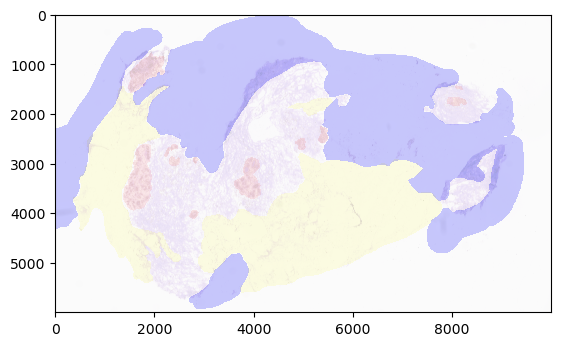

saved:  ../data/hne_img_png_annot/hne_pos_pid7_day1.png





In [33]:
for i, row in df_sample_pos.query('sid == @sid').iterrows():

    if os.path.isfile('../data/hne_img_png/hne_{}_{}.png'.format(row.ions, i)):
        img_crop = cv2.imread('../data/hne_img_png/hne_{}_{}.png'.format(row.ions, i))
        xmin = int(row.xmin)
        ymin = int(row.ymin)
        xmax = int(row.xmax)
        ymax = int(row.ymax)
    
        img_mask = np.zeros((img_crop.shape[0], img_crop.shape[1], 5))
    
        for fname in fnlist_mask_sub:
            fn = fname.split('.svs_')[-1].split('-mask')[0]
            r, x, y, w, h = fn.split('(')[-1].split(')')[0].split(',')
            x, y, w, h = int(x), int(y), int(w), int(h)
            anno = fn.split('_(')[0]
    
            if (xmin - d_extra < y) & (xmax + d_extra > y + h) & (ymin - d_extra < x) & (ymax + d_extra > x + w):
                image = cv2.imread(fname)

                # plt.imshow(image)
                image[image != 0] = dict_label[anno]

                if image.shape[0] > img_crop.shape[0]:
                    if x - ymin < 0:
                        image = image[x-ymin:image.shape[0], :,:]
                        x = ymin
                    if image.shape[0] > img_crop.shape[0]:
                        image = image[0:img_crop.shape[0],:,:]
                
                if image.shape[1] > img_crop.shape[1]:
                    if y - xmin < 0:
                        image = image[:,y-xmin:image.shape[1],:]
                        y = xmin
                    if image.shape[1] > img_crop.shape[1]:
                        image = image[:,0:img_crop.shape[1],:]

                    
                
                bigimage = create_img_bydim(image, img_crop.shape[0], img_crop.shape[1])
                bigimage_shift = shift(bigimage[:,:,0], (y - xmin, x - ymin), mode='constant')
    
                img_mask[:,:,dict_label[anno]-1] = img_mask[:,:,dict_label[anno]-1] + bigimage_shift

        
        
        for anno in dict_label.keys():
            img_mask[:,:,dict_label[anno]-1][img_mask[:,:,dict_label[anno]-1] != 0] = dict_label[anno]
            
        # create directory if it does not exist
        p = Path('../data/hne_img_png_annot')
        p.mkdir(parents=True, exist_ok=True)

        print('# of masks: ',img_mask.shape)
        plt.imshow(img_crop)
        for j in range(img_mask.shape[2]):
            cmap = mpl.colors.ListedColormap(['white', clist[j]])
            plt.imshow(img_mask[:,:,j], alpha=0.3, cmap=cmap)
            fignm = '../data/hne_img_png_annot/hne_{}_{}.png'.format(row.ions, i)
        savenm = '../data/hne_img_png_annot/hne_{}_{}.npy'.format(row.ions, i)
        np.save(savenm, img_mask)
        plt.savefig(fignm)
        plt.show()
        print('saved: ', fignm)
        

    print('\n\n')
    

In [34]:
def bimask_close(batch, charge, iter=1, saveit=True, verbose=True):
    """ Create binary mask using H&E image """
    
    fn = '../data/hne_img_png/hne_{}_{}.png'.format(charge, batch)
    
    if os.path.isfile(fn):
        img = sitk.ReadImage(fn, sitk.sitkFloat32)
        img = sitk.GetArrayFromImage(img)
    
        img = img.max()-img
    
        aa = plt.hist(img.flatten(), bins=50)
        
        slope_diff = np.diff(aa[0])/np.diff(aa[1][1:])
        val_diff = slope_diff[slope_diff>0][0]
        id_diff = list(slope_diff).index(val_diff)

        k = 1
        cutoff = aa[1][id_diff + k]
        while cutoff < 7000:
            k = k+1
            cutoff = aa[1][id_diff + k]
            
        biimg = img > cutoff
    
        if verbose:
            print('cutoff is {} with {}'.format(cutoff, k))
            

        img_cl = binary_fill_holes(biimg).astype(int)
        # img_cl = binary_closing(biimg, iterations=iter).astype(int)
    
        if verbose:
            Path('../data/hne_img_png_mask/QC').mkdir(parents=True, exist_ok=True) 
            
            plt.subplot(221)
            aa = plt.hist(img.flatten(), bins=50)
            
            plt.subplot(222)
            plt.scatter(aa[1][1:],aa[0], s=5, marker='o', c='black')
            plt.scatter(aa[1][id_diff+k+1],aa[0][id_diff+ k], s=5, marker='o', c='red')
            
            plt.subplot(234)
            plt.imshow(img)
            
            plt.subplot(235)
            plt.imshow(biimg)
            
            plt.subplot(236)
            plt.imshow(img_cl)
    
            plt.suptitle('{} {}'.format(batch, charge), fontsize=10)
    
            fignm = '../data/hne_img_png_mask/QC/hne_{}_{}_binarymask.png'.format(charge, batch)
            plt.savefig(fignm)
    
            plt.show()

    if saveit:
        Path('../data/hne_img_png_mask').mkdir(parents=True, exist_ok=True) 
        
        savenm = '../data/hne_img_png_mask/hne_{}_{}_binarymask.png'.format(charge, batch)
        mpl.image.imsave(savenm, img_cl)
        if verbose:
            print('img was saved as {}'.format(savenm))
    else:
        print('no file exists: ','../data/spmeta_hne_img/hne_{}_{}.png'.format(charge, batch))

In [35]:
def qumask2png(batch, charge, verbose=True):
    """ combine binary masks for a given tissue, then save as png """
    
    if os.path.isfile('../data/hne_img_png/hne_{}_{}.png'.format(charge, batch)):
        img_crop = cv2.imread('../data/hne_img_png/hne_{}_{}.png'.format(charge, batch))
         
        img_annot = np.load('../data/hne_img_png_annot/hne_{}_{}.npy'.format(charge, batch))
        img_bi = cv2.imread('../data/hne_img_png_mask/hne_{}_{}_binarymask.png'.format(charge, batch))
        
        if verbose:
            print('images were loaded..')
        
        
        # make binary image to grey scale binary image
        img_bi = img_bi[:,:,1] 
        img_bi[img_bi == 1] = 0
        img_bi[img_bi != 0] = 1
        
        # remove small clusters from binary mask (default: less than 50000 pixels)
        cutoff_px = 50000
        labeled_array, num_features = label(img_bi)
        uniq, cts = np.unique(labeled_array, return_counts=True)
        img_bi[np.isin(labeled_array, uniq[cts <  cutoff_px])] = 0
        img_bi[np.isin(labeled_array, uniq[cts >=  cutoff_px][1:])] = 10
        
        # set colors
        colors = ['white','grey','blue','yellow','green']#,'cyan']
        
        scale = range(0, 5)
        
        cmap=mpl.colors.ListedColormap(colors[:5])

        
        if verbose:
            plt.rcParams["figure.figsize"] = (10,5)
            plt.subplot(1,3,1)
            plt.imshow(img_crop)
            plt.subplot(1,3,2)
            plt.imshow(img_bi, cmap=mpl.colors.ListedColormap(colors[:2]))
        k = 3
        for j in [0,1,2,3,4]:
            if (j == 3) or (j == 4):
                img_bi[img_annot[:,:,j] != 0] = 0
            else:
                if np.sum(img_annot[:,:,j] != 0) > 0:
                    img_bi[img_annot[:,:,j] != 0] = (j+1)
                    # print(k,j, np.unique(img_bi))
                    k = k+1

        # remove small clusters again
        labeled_array, num_features = label(img_bi)
        uniq, cts = np.unique(labeled_array, return_counts=True)
        img_bi[np.isin(labeled_array, uniq[cts <  cutoff_px])] = 0
        
                    
        img = np.empty((*img_bi.shape, 3), dtype=np.uint8)
        
        img[img_bi == 0] = (255, 255, 255)  # RGB -> white
        img[img_bi == 1] = (0,0,255)        #        blue, N - normal glandular
        img[img_bi == 2] = (255,0,0)        #        red, adipocytes
        img[img_bi == 3] = (0,255,0)        #        green, blood vessel
        img[img_bi == 10] = (125,125,125)   #        grey, unknown
        

        if verbose:
            plt.subplot(1,3,3)
            plt.imshow(img)
                        
            # cax = plt.axes((0.95, 0.9, 0.02, 0.1))
            # plt.colorbar(cax=cax, cmap=cmap, norm=norm, ticks=range(0, 5))
            plt.show()
    
    
        # read image used for image registration, and resize the annotated image based on that
        if os.path.isfile('../data/spmeta_hne_img/hne_{}_{}.png'.format(charge, batch)):
            tmpimg = cv2.imread('../data/spmeta_hne_img/hne_{}_{}.png'.format(charge, batch))

            img = imutils.resize(img, width=tmpimg.shape[1] ,height=tmpimg.shape[0], inter = cv2.INTER_NEAREST)
            # rotate image
            img = cv2.rotate(img, cv2.ROTATE_180)

        else:
            tmpimg = cv2.imread('../data/spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch))
            tmpimg.shape
        
            # rotate image
            img = cv2.rotate(img, cv2.ROTATE_180)
        
            l_img = np.max(tmpimg.shape)
        
            r = img.shape[0] / img.shape[1]
            if r > 1:
                img = imutils.resize(img, height=l_img, inter = cv2.INTER_NEAREST)
            else:
                img = imutils.resize(img, width=l_img, inter = cv2.INTER_NEAREST)
    
        # save resized annotated image
        Path('../data/spmeta_hne_img_annot').mkdir(parents=True, exist_ok=True) 
        savenm = '../data/spmeta_hne_img_annot/spmeta_{}_{}_annot.png'.format(charge, batch)
        mpl.image.imsave(savenm, img)
    
        print('done --', batch, charge)

    else:
        print('image file does not exist: {} - {}'.format(batch, charge))



cutoff is 7803.0 with 6


/tmp/ipykernel_405039/2883723632.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


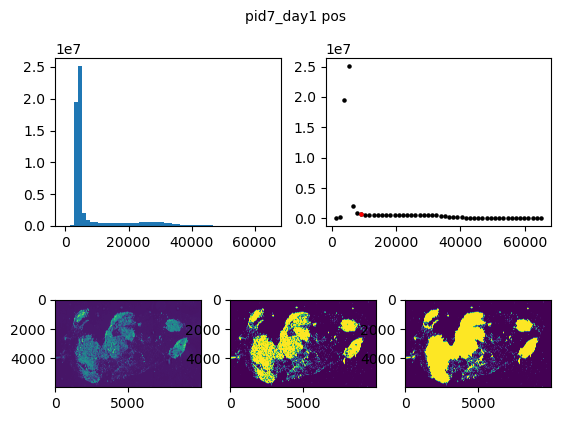

img was saved as ../data/hne_img_png_mask/hne_pos_pid7_day1_binarymask.png
images were loaded..


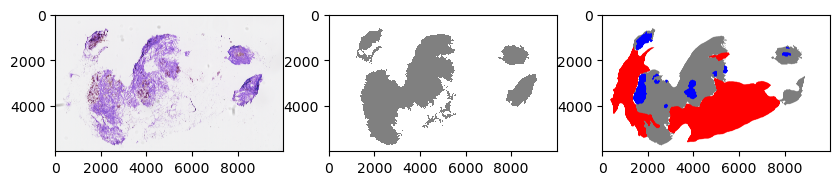

done -- pid7_day1 pos


In [36]:
for i, row in df_sample_pos.query('sid == @sid').iterrows():
    bimask_close(batch, charge, iter=1, saveit=True, verbose=True)
    qumask2png(i, row.ions, verbose=True)
